In [1]:
from astropy.io import fits
import numpy as np
import os.path
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.nddata import Cutout2D
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import matplotlib.gridspec as gridspec
import aplpy
import pandas as pd
from photutils import SkyCircularAperture
from photutils import aperture_photometry
%matplotlib inline

In [2]:
path = '/Users/justin/Documents/Master_Thesis/data/catalogues/chandra_7ms/big_table.fits'
big_table = fits.open(path)[1].data

#path = '/Users/justin/Documents/Master_Thesis/data/catalogues/cutouts/something.cat'
#cat = pd.read_csv(path, delim_whitespace=True, header=None, names=['whatever'], skiprows=None)

#begin analysis
mbh=10e6 #solar masses
er=0.01
z=5.
kcorr=25.
gamma=1.8
nh=10e22 #cm-2
flsoft=6.4*10e-18 #erg cm-2 s-1
flhard=2.7*10e-17 #erg cm-2 s-1

#go from mbh to bolometric luminonity using er: formula

#go from bolometric luminosity to X-ray luminosity using kcorr (see Vasudevan & Fabian 2009, Treister 2011)

#transform from rest-frame X-ray luminosity to flux at a certain redshift and photon index (using formula given by Benny that includes k corrections)

#use nh to calculate extinction in soft band (use XSPEC?)
    

In [3]:
#calculate m1450 from template
path = '/Users/justin/Documents/Master_Thesis/data/catalogues/chandra_7ms/tbl04.fits'
cat = fits.open(path)[1].data
xid=[527,622,640,714]
z_grid=[3.,3.5,4.,4.5,5.,5.5,6.,6.5,7.,7.5,8.]
d_l=[25417.2,30575.2,35842.1,41200.5,46637.4,52142.5,57707.7,63326.5,68993.5,74704.0,80454.2] #Mpc luminosity distance based on redshift (Ned Wright cosm. calc.)
m_mean=0.
m_var_l=0.
m_var_u=0.
for i in range(len(xid)):
    if xid[i] == 622:
        path_sed = '/Users/justin/Documents/Master_Thesis/softwares/eazy/inputs/OUTPUT_zspec/photz_' + str(xid[i]) + '.temp_sed'
        zphot=5.75
        cat_sed = pd.read_csv(path_sed, delim_whitespace=True, header=None, names=['Wavelength', 'Flux'], skiprows=[0,1])
        w1450=1450.*(zphot+1) #angstrom
        f1450=np.interp(w1450,cat_sed['Wavelength'],cat_sed['Flux']) #Jansky
        #convert from Jansky to AB absolute magnitude (defined as flux from 10 parsec - 32.6 ly)
        m1450=-2.5*np.log10(f1450*((np.interp(zphot,z_grid,d_l)*1000000./10.)**2)/3631.)
        print(xid[i], m1450, zphot)
    else:
        path_sed = '/Users/justin/Documents/Master_Thesis/softwares/eazy/inputs/OUTPUT/photz_' + str(xid[i]) + '.temp_sed'
        path_le = '/Users/justin/Documents/Master_Thesis/softwares/eazy/inputs/OUTPUT_zspec/photz_' + str(xid[i]) + '.temp_sed'
        path_ue = '/Users/justin/Documents/Master_Thesis/softwares/eazy/inputs/OUTPUT_zspec/photz_' + str(xid[i]+1) + '.temp_sed'
        zphot=big_table.field('Phot_z')[xid[i]-1]
        zphot_l=big_table.field('Phot_z_l1')[xid[i]-1]
        zphot_u=big_table.field('Phot_z_u1')[xid[i]-1]
        cat_sed = pd.read_csv(path_sed, delim_whitespace=True, header=None, names=['Wavelength', 'Flux'], skiprows=[0,1])
        cat_le = pd.read_csv(path_sed, delim_whitespace=True, header=None, names=['Wavelength', 'Flux'], skiprows=[0,1])
        cat_ue = pd.read_csv(path_sed, delim_whitespace=True, header=None, names=['Wavelength', 'Flux'], skiprows=[0,1])
    
        w1450=1450.*(zphot+1) #angstrom
        w1450_l=1450.*(zphot_l+1)
        w1450_u=1450.*(zphot_u+1)
        f1450=np.interp(w1450,cat_sed['Wavelength'],cat_sed['Flux']) #Jansky
        f1450_l=np.interp(w1450_l,cat_le['Wavelength'],cat_le['Flux'])
        f1450_u=np.interp(w1450_u,cat_ue['Wavelength'],cat_ue['Flux'])
        #convert from Jansky to AB absolute magnitude (defined as flux from 10 parsec - 32.6 ly)
        m1450=-2.5*np.log10(f1450*((np.interp(zphot,z_grid,d_l)*1000000./10.)**2)/3631.)
        m1450_l=-2.5*np.log10(f1450_l*((np.interp(zphot_l,z_grid,d_l)*1000000./10.)**2)/3631.)
        m1450_u=-2.5*np.log10(f1450_u*((np.interp(zphot_u,z_grid,d_l)*1000000./10.)**2)/3631.)
        print(xid[i], m1450, m1450_l, m1450_u, zphot, zphot_l, zphot_u)
        print('%.2f^{+%.2f}_{-%.2f}' % (m1450, m1450_l-m1450, m1450-m1450_u))
        m_mean+=m1450
        m_var_l+=(m1450-m1450_l)**2
        m_var_u+=(m1450_u-m1450)**2
m_mean=m_mean/3.
m_var_l=(m_var_l**0.5)/3.
m_var_u=(m_var_u**0.5)/3.
print(m_mean, m_var_l, m_var_u)

527 -20.5262908906 -19.8019984436 -21.3516723914 4.996 4.502 5.833
-20.53^{+0.72}_{-0.83}
622 -20.9943628752 5.75
640 -21.8265499846 -20.6945243298 -22.8708085224 6.031 5.071 7.503
-21.83^{+1.13}_{-1.04}
714 -20.9795458423 -20.6799297275 -21.7879410633 5.177 4.991 6.026
-20.98^{+0.30}_{-0.81}
-21.1107955725 0.458966404986 0.519105357418


-5.43740618431 -5.91452743902 -5.65183909472 0.295053706105 0.341352740152 0.761953896871 0.518513939878
2.50182261461 2.78431978601 1.103e+10


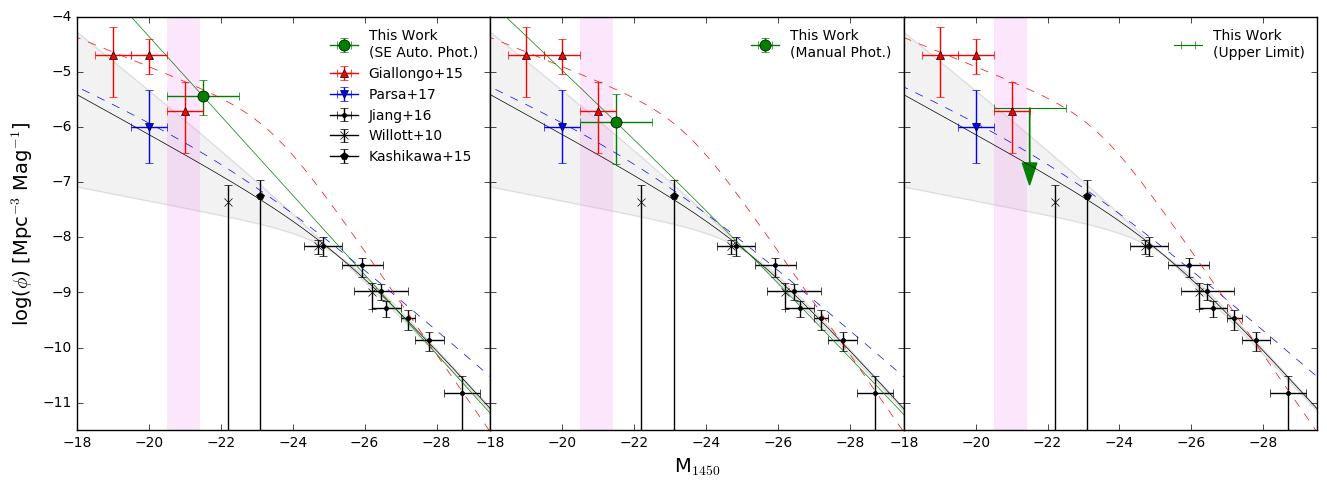

In [17]:
#UV qlf determination
#first point (se phot): -20.5 to -22.5 (3 sources), with z=5-6.5 bin
# second point (manual phot): -20.5 to -22.5 (could choose -21.5) (1 source 714), with z= 5.0-6.5 bin
#evt upper limit, no sources are high z (z=5 to 6.5 bin)

n=[0,1,2,3]
l=[0,0.173,0.708,1.367] #Poissonian 1-sigma Gaussian upper and lower limits for n counts (Gehrels 1986)
u=[1.831,3.300,4.638,5.918]

goods_s=110/3600 #deg2, only CANDELS region
whole_sky=(360.**2)/np.pi #deg2
sky_frac = goods_s/whole_sky

vol_com_5 = 1967.314 #Gpc3 (note: comoving volume within redshift z, might want luminosity distance instead)
vol_com_5_5 = 2162.529
vol_com_6_5 = 2521.764 #Gpc3

vol_tot = sky_frac * (vol_com_6_5 - vol_com_5) * (1000**3) #Mpc3
vol_tot2= sky_frac * (vol_com_6_5 - vol_com_5) * (1000**3)
vol_tot3= sky_frac * (vol_com_6_5 - vol_com_5) * (1000**3)

density_tot = 3. / vol_tot / 2. #Mpc-3 Mag-1
density_tot2= 1. / vol_tot2/ 2.
density_tot3= 1.831 / vol_tot3/ 2.

print(np.log10(density_tot), np.log10(density_tot2), np.log10(density_tot3), np.log10(5.918/3.), np.log10(3./1.367), np.log10(1./0.173), np.log10(3.300/1.))

def lf_dp(m,beta=1.75,gamma=2.41,m_star=-22.58,log_phi_star=-6.62):
    num=10.**log_phi_star
    denom=10.**(0.4*(m_star-m)*(beta-1.))+10.**(0.4*(m_star-m)*(gamma-1.))
    return np.log10(num/denom)
def lf_sp(m, gamma=2.8,norm=1.):
    num=norm
    denom=10.**(0.4*(-m)*(gamma-1.))
    return np.log10(num/denom)
norm1 = density_tot*10.**(0.4*(21.5)*(2.8-1.))
beta_zim2=1. + np.log10((9.93*(10**(-9))/density_tot2)-10**(2./5.*(-25.2+21.5)*(2.8-1.)))/(2./5.*(-25.2+21.5))
beta_zimup=1. + np.log10((9.93*(10**(-9))/density_tot3)-10**(2./5.*(-25.2+21.5)*(2.8-1.)))/(2./5.*(-25.2+21.5))
beta_var=2.15
print(beta_zim2, beta_zimup, '%.3e' % norm1)
m_grid=[]
phi_parsa=[]
phi_giallongo=[]
phi_jiang=[]
phi_jiang_u=[]
phi_jiang_l=[]
phi_zim1=[]
phi_zim2=[]
phi_zimup=[]
phi_zimvar=[]
for i in range(0,140):
    m_grid.append(-30.+(i*0.1))
    phi_parsa.append(lf_dp(m_grid[i]))
    phi_giallongo.append(lf_dp(m_grid[i],beta=1.66,gamma=3.35,m_star=-23.4,log_phi_star=-5.8))
    phi_jiang.append(lf_dp(m_grid[i],beta=1.9,gamma=2.8,m_star=-25.2,log_phi_star=np.log10(9.93*(10**(-9)))))
    phi_jiang_u.append(lf_dp(m_grid[i],beta=1.32,gamma=2.8,m_star=-25.2,log_phi_star=np.log10(9.93*(10**(-9)))))
    phi_jiang_l.append(lf_dp(m_grid[i],beta=2.3,gamma=2.8,m_star=-25.2,log_phi_star=np.log10(9.93*(10**(-9)))))
    phi_zim1.append(lf_sp(m_grid[i],gamma=2.8, norm=norm1))
    phi_zim2.append(lf_dp(m_grid[i],beta=beta_zim2,gamma=2.8,m_star=-25.2,log_phi_star=np.log10(9.93*(10**(-9)))))
    phi_zimup.append(lf_dp(m_grid[i],beta=beta_zimup,gamma=2.8,m_star=-25.2,log_phi_star=np.log10(9.93*(10**(-9)))))
    phi_zimvar.append(lf_dp(m_grid[i],beta=beta_var,gamma=2.8,m_star=-25.2,log_phi_star=np.log10(9.93*(10**(-9)))))


    
f=plt.figure(figsize=(16,8))
ax=f.add_subplot(131)
ax.plot(m_grid,phi_parsa,ls='--',lw=0.5,marker='',color='blue')
ax.plot(m_grid,phi_giallongo,ls='--',lw=0.5,marker='',color='red')
ax.plot(m_grid,phi_jiang,ls='-',lw=0.5,marker='',color='black')
ax.plot(m_grid,phi_zim1,ls='-',lw=0.5,marker='',color='green')
ax.fill_between(m_grid, phi_jiang_l, phi_jiang_u, facecolor='gray',alpha=0.1)
ax.fill_between([-20.963-0.46,-20.963+0.46], -13, -3, facecolor='violet',lw=0,alpha=0.2)
plt.gca().invert_xaxis()
plt.axis([-18,-29.5,-11.5,-4])
ax.set_aspect((11.5/7.5))
#plt.title('$z\simeq5.75$')
plt.ylabel('log($\phi$) [Mpc$^{-3}$ Mag$^{-1}$]', size=14)
ax.errorbar(-21.5,np.log10(density_tot), xerr=1., yerr=[[np.log10(3./1.367)],[np.log10(5.918/3.)]], marker='o', ms=8, color='green',label='This Work\n(SE Auto. Phot.)')
#ax.arrow((m_bin1+m_bin2)/2.,np.log10(density_bin1), 0., -0.5, head_width=0.3, head_length=0.3, fc='k', ec='k', lw=0.6)
#ax.arrow((m_bin2+m_bin3)/2.,np.log10(density_bin2), 0., -0.5, head_width=0.3, head_length=0.3, fc='k', ec='k', lw=0.6)
ax.errorbar(-19.,-4.7, xerr=0.5, yerr=[[np.log10(1./0.173)],[np.log10(3.300/1.)]], marker='^', color='red',label='Giallongo+15')
ax.errorbar(-20.,-4.7, xerr=0.5, yerr=[[np.log10(3./1.367)],[np.log10(5.918/3.)]], marker='^', color='red')
ax.errorbar(-21,-5.7, xerr=0.5, yerr=[[np.log10(1./0.173)],[np.log10(3.300/1.)]], marker='^', color='red')
ax.errorbar(-20,-5.99, xerr=0.5, yerr=0.66, marker='v', color='blue',label='Parsa+17')
ax.errorbar(-24.83, np.log10(7.1*(10**(-9))), xerr=0.53, yerr=[[np.log10(7.*(10**(-9)))-np.log10(4.5*(10**(-9)))],[np.log10(10.*(10**(-9)))-np.log10(7.*(10**(-9)))]], marker='.', color='black', label='Jiang+16')
ax.errorbar(-25.93,np.log10(3.16*(10**(-9))), xerr=0.57, yerr=[[np.log10(3.2*(10**(-9)))-np.log10(1.9*(10**(-9)))],[np.log10(4.3*(10**(-9)))-np.log10(3.2*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-26.45,np.log10(1.055*(10**(-9))), xerr=0.75, yerr=[[np.log10(1.05*(10**(-9)))-np.log10(0.71*(10**(-9)))],[np.log10(1.4*(10**(-9)))-np.log10(1.05*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-26.6,np.log10(0.527*(10**(-9))), xerr=0.4, yerr=[[np.log10(0.52*(10**(-9)))-np.log10(0.35*(10**(-9)))],[np.log10(0.7*(10**(-9)))-np.log10(0.52*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-27.2,np.log10(0.343*(10**(-9))), xerr=0.2, yerr=[[np.log10(0.34*(10**(-9)))-np.log10(0.21*(10**(-9)))],[np.log10(0.47*(10**(-9)))-np.log10(0.34*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-27.8,np.log10(0.136*(10**(-9))), xerr=0.4, yerr=[[np.log10(0.13*(10**(-9)))-np.log10(0.083*(10**(-9)))],[np.log10(0.185*(10**(-9)))-np.log10(0.13*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-28.7,np.log10(0.0151*(10**(-9))), xerr=0.5, yerr=[[np.log10(0.015*(10**(-9)))-np.log10(0.001*(10**(-9)))],[np.log10(0.03*(10**(-9)))-np.log10(0.015*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-24.7,np.log10(7.*(10**(-9))), yerr=[[np.log10(7.*(10**(-9)))-np.log10(5.*(10**(-9)))],[np.log10(9.*(10**(-9)))-np.log10(7.*(10**(-9)))]], marker='x', color='black',label="Willott+10")
ax.errorbar(-22.2,np.log10(43.8*(10**(-9))), yerr=[[np.log10(45.*(10**(-9)))-np.log10(0.0001*(10**(-9)))],[np.log10(90.*(10**(-9)))-np.log10(45.*(10**(-9)))]], marker='x', color='black')
ax.errorbar(-26.2,np.log10(1.*(10**(-9))), yerr=[[np.log10(1.*(10**(-9)))-np.log10(0.5*(10**(-9)))],[np.log10(1.5*(10**(-9)))-np.log10(1.*(10**(-9)))]], marker='x', color='black')
ax.errorbar(-23.1,np.log10(55.4*(10**(-9))), yerr=[[np.log10(55.*(10**(-9)))-np.log10(0.0001*(10**(-9)))],[np.log10(110.*(10**(-9)))-np.log10(55.*(10**(-9)))]], marker='p', color='black',label='Kashikawa+15')

#Jiang (−25.1 0.17) is (7.5±3.8)×10−9, (−25.8 0.42) is (5.0 ± 2.1) × 10−9, (-26.75 0.15) 1.6 0.92 2.2 10-9, (-27.13 0.25) 0.42 0.6 0.25 10-9, (-27.63 0.25) 0.25 0.36 0.13 10-9
plt.legend(numpoints=1, bbox_to_anchor=(1.,1.), fontsize=10, frameon=False)

path = '/Users/justin/Documents/Master_Thesis/presentation/plots/UV_QLF1.pdf'
plt.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')

ax=f.add_subplot(132)
ax.plot(m_grid,phi_parsa,ls='--',lw=0.5,marker='',color='blue')
ax.plot(m_grid,phi_giallongo,ls='--',lw=0.5,marker='',color='red')
ax.plot(m_grid,phi_jiang,ls='-',lw=0.5,marker='',color='black')
ax.plot(m_grid,phi_zim2,ls='-',lw=0.5,marker='',color='green')
ax.fill_between(m_grid, phi_jiang_l, phi_jiang_u, facecolor='gray',alpha=0.1)
ax.fill_between([-20.963-0.46,-20.963+0.46], -13, -3, facecolor='violet',lw=0,alpha=0.2)
plt.gca().invert_xaxis()
plt.axis([-18,-29.5,-11.5,-4])
ax.set_aspect((11.5/7.5))
#plt.title('$z\simeq5.75$')
plt.xlabel('M$_{1450}$', size=14)
ax.errorbar(-21.5,np.log10(density_tot2), xerr=1., yerr=[[np.log10(1./0.173)],[np.log10(3.300/1.)]], marker='o', ms=8, color='green',label='This Work\n(Manual Phot.)')
#ax.arrow((m_bin1+m_bin2)/2.,np.log10(density_bin1), 0., -0.5, head_width=0.3, head_length=0.3, fc='k', ec='k', lw=0.6)
#ax.arrow((m_bin2+m_bin3)/2.,np.log10(density_bin2), 0., -0.5, head_width=0.3, head_length=0.3, fc='k', ec='k', lw=0.6)
ax.errorbar(-19.,-4.7, xerr=0.5, yerr=[[np.log10(1./0.173)],[np.log10(3.300/1.)]], marker='^', color='red')
ax.errorbar(-20.,-4.7, xerr=0.5, yerr=[[np.log10(3./1.367)],[np.log10(5.918/3.)]], marker='^', color='red')
ax.errorbar(-21,-5.7, xerr=0.5, yerr=[[np.log10(1./0.173)],[np.log10(3.300/1.)]], marker='^', color='red')
ax.errorbar(-20,-5.99, xerr=0.5, yerr=0.66, marker='v', color='blue')
ax.errorbar(-24.83, np.log10(7.1*(10**(-9))), xerr=0.53, yerr=[[np.log10(7.*(10**(-9)))-np.log10(4.5*(10**(-9)))],[np.log10(10.*(10**(-9)))-np.log10(7.*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-25.93,np.log10(3.16*(10**(-9))), xerr=0.57, yerr=[[np.log10(3.2*(10**(-9)))-np.log10(1.9*(10**(-9)))],[np.log10(4.3*(10**(-9)))-np.log10(3.2*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-26.45,np.log10(1.055*(10**(-9))), xerr=0.75, yerr=[[np.log10(1.05*(10**(-9)))-np.log10(0.71*(10**(-9)))],[np.log10(1.4*(10**(-9)))-np.log10(1.05*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-26.6,np.log10(0.527*(10**(-9))), xerr=0.4, yerr=[[np.log10(0.52*(10**(-9)))-np.log10(0.35*(10**(-9)))],[np.log10(0.7*(10**(-9)))-np.log10(0.52*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-27.2,np.log10(0.343*(10**(-9))), xerr=0.2, yerr=[[np.log10(0.34*(10**(-9)))-np.log10(0.21*(10**(-9)))],[np.log10(0.47*(10**(-9)))-np.log10(0.34*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-27.8,np.log10(0.136*(10**(-9))), xerr=0.4, yerr=[[np.log10(0.13*(10**(-9)))-np.log10(0.083*(10**(-9)))],[np.log10(0.185*(10**(-9)))-np.log10(0.13*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-28.7,np.log10(0.0151*(10**(-9))), xerr=0.5, yerr=[[np.log10(0.015*(10**(-9)))-np.log10(0.001*(10**(-9)))],[np.log10(0.03*(10**(-9)))-np.log10(0.015*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-24.7,np.log10(7.*(10**(-9))), yerr=[[np.log10(7.*(10**(-9)))-np.log10(5.*(10**(-9)))],[np.log10(9.*(10**(-9)))-np.log10(7.*(10**(-9)))]], marker='x', color='black')
ax.errorbar(-22.2,np.log10(43.8*(10**(-9))), yerr=[[np.log10(45.*(10**(-9)))-np.log10(0.0001*(10**(-9)))],[np.log10(90.*(10**(-9)))-np.log10(45.*(10**(-9)))]], marker='x', color='black')
ax.errorbar(-26.2,np.log10(1.*(10**(-9))), yerr=[[np.log10(1.*(10**(-9)))-np.log10(0.5*(10**(-9)))],[np.log10(1.5*(10**(-9)))-np.log10(1.*(10**(-9)))]], marker='x', color='black')
ax.errorbar(-23.1,np.log10(55.4*(10**(-9))), yerr=[[np.log10(55.*(10**(-9)))-np.log10(0.0001*(10**(-9)))],[np.log10(110.*(10**(-9)))-np.log10(55.*(10**(-9)))]], marker='p', color='black')
plt.setp(ax.get_yticklabels(), visible=False)
#Jiang (−25.1 0.17) is (7.5±3.8)×10−9, (−25.8 0.42) is (5.0 ± 2.1) × 10−9, (-26.75 0.15) 1.6 0.92 2.2 10-9, (-27.13 0.25) 0.42 0.6 0.25 10-9, (-27.63 0.25) 0.25 0.36 0.13 10-9
plt.legend(numpoints=1, bbox_to_anchor=(1.,1.), fontsize=10, frameon=False)

path = '/Users/justin/Documents/Master_Thesis/presentation/plots/UV_QLF2.pdf'
plt.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')

ax=f.add_subplot(133)
ax.plot(m_grid,phi_parsa,ls='--',lw=0.5,marker='',color='blue')
ax.plot(m_grid,phi_giallongo,ls='--',lw=0.5,marker='',color='red')
ax.plot(m_grid,phi_jiang,ls='-',lw=0.5,marker='',color='black')
ax.fill_between(m_grid, phi_jiang_l, phi_jiang_u, facecolor='gray',alpha=0.1)
#-20.9634818906 0.46 -22.2094046415 -20.0957989327
ax.fill_between([-20.963-0.46,-20.963+0.46], -13, -3, facecolor='violet',lw=0,alpha=0.2)
plt.gca().invert_xaxis()
plt.axis([-18,-29.5,-11.5,-4])
ax.set_aspect((11.5/7.5))
#plt.title('$z\simeq5.75$')
ax.errorbar(-21.5,np.log10(density_tot3), xerr=1., marker='', color='green', lw=0.8,label='This Work\n(Upper Limit)')
ax.arrow(-21.5,np.log10(density_tot3), 0., -1., head_width=0.4, head_length=0.4, fc='green', ec='green')
#ax.arrow((m_bin2+m_bin3)/2.,np.log10(density_bin2), 0., -0.5, head_width=0.3, head_length=0.3, fc='k', ec='k', lw=0.6)
ax.errorbar(-19.,-4.7, xerr=0.5, yerr=[[np.log10(1./0.173)],[np.log10(3.300/1.)]], marker='^', color='red')
ax.errorbar(-20.,-4.7, xerr=0.5, yerr=[[np.log10(3./1.367)],[np.log10(5.918/3.)]], marker='^', color='red')
ax.errorbar(-21,-5.7, xerr=0.5, yerr=[[np.log10(1./0.173)],[np.log10(3.300/1.)]], marker='^', color='red')
ax.errorbar(-20,-5.99, xerr=0.5, yerr=0.66, marker='v', color='blue')
ax.errorbar(-24.83, np.log10(7.1*(10**(-9))), xerr=0.53, yerr=[[np.log10(7.*(10**(-9)))-np.log10(4.5*(10**(-9)))],[np.log10(10.*(10**(-9)))-np.log10(7.*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-25.93,np.log10(3.16*(10**(-9))), xerr=0.57, yerr=[[np.log10(3.2*(10**(-9)))-np.log10(1.9*(10**(-9)))],[np.log10(4.3*(10**(-9)))-np.log10(3.2*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-26.45,np.log10(1.055*(10**(-9))), xerr=0.75, yerr=[[np.log10(1.05*(10**(-9)))-np.log10(0.71*(10**(-9)))],[np.log10(1.4*(10**(-9)))-np.log10(1.05*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-26.6,np.log10(0.527*(10**(-9))), xerr=0.4, yerr=[[np.log10(0.52*(10**(-9)))-np.log10(0.35*(10**(-9)))],[np.log10(0.7*(10**(-9)))-np.log10(0.52*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-27.2,np.log10(0.343*(10**(-9))), xerr=0.2, yerr=[[np.log10(0.34*(10**(-9)))-np.log10(0.21*(10**(-9)))],[np.log10(0.47*(10**(-9)))-np.log10(0.34*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-27.8,np.log10(0.136*(10**(-9))), xerr=0.4, yerr=[[np.log10(0.13*(10**(-9)))-np.log10(0.083*(10**(-9)))],[np.log10(0.185*(10**(-9)))-np.log10(0.13*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-28.7,np.log10(0.0151*(10**(-9))), xerr=0.5, yerr=[[np.log10(0.015*(10**(-9)))-np.log10(0.001*(10**(-9)))],[np.log10(0.03*(10**(-9)))-np.log10(0.015*(10**(-9)))]], marker='.', color='black')
ax.errorbar(-24.7,np.log10(7.*(10**(-9))), yerr=[[np.log10(7.*(10**(-9)))-np.log10(5.*(10**(-9)))],[np.log10(9.*(10**(-9)))-np.log10(7.*(10**(-9)))]], marker='x', color='black')
ax.errorbar(-22.2,np.log10(43.8*(10**(-9))), yerr=[[np.log10(45.*(10**(-9)))-np.log10(0.0001*(10**(-9)))],[np.log10(90.*(10**(-9)))-np.log10(45.*(10**(-9)))]], marker='x', color='black')
ax.errorbar(-26.2,np.log10(1.*(10**(-9))), yerr=[[np.log10(1.*(10**(-9)))-np.log10(0.5*(10**(-9)))],[np.log10(1.5*(10**(-9)))-np.log10(1.*(10**(-9)))]], marker='x', color='black')
ax.errorbar(-23.1,np.log10(55.4*(10**(-9))), yerr=[[np.log10(55.*(10**(-9)))-np.log10(0.0001*(10**(-9)))],[np.log10(110.*(10**(-9)))-np.log10(55.*(10**(-9)))]], marker='p', color='black')
plt.setp(ax.get_yticklabels(), visible=False)
#Jiang (−25.1 0.17) is (7.5±3.8)×10−9, (−25.8 0.42) is (5.0 ± 2.1) × 10−9, (-26.75 0.15) 1.6 0.92 2.2 10-9, (-27.13 0.25) 0.42 0.6 0.25 10-9, (-27.63 0.25) 0.25 0.36 0.13 10-9
plt.legend(numpoints=1, bbox_to_anchor=(1.,1.), fontsize=10, frameon=False)
plt.subplots_adjust(wspace = 0.)
path = '/Users/justin/Documents/Master_Thesis/presentation/plots/UV_QLF3.pdf'
plt.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')
#make M1450 bins:

#need binning our sample: 1st option: make simple z=[5,6.5] bin, all 5 sources fall into it, possibly leave out 527
#are these detections, or upper limit on number of detections?

#then check M1450 using a redshift of 5.75 to get to rest-frame

#get 5.75 QLF for far UV using M bins (-19,-20, etc...) and calculating space density

#calculate ionising fraction: eq(1) in Parsa. only usable if get parameters of QLF fit. BUT
#these parameters are going to be almost exactly the same as Giallongo.

#if so then only get one upper limit for emissivity, which will agree widely with Giallongo

#conclusion: will be difficult to argue against AGN reionising universe based on these results, if we incorporate
#all 5 sources in the redshift bin.

In [5]:
#fit qlf, integrate faint end from -20 to break:
m_integral = np.linspace(-28., -20.5, 20)
phi_integraljiang = np.interp(m_integral, m_grid, phi_jiang)
phi_integralparsa = np.interp(m_integral, m_grid, phi_parsa)
phi_integralgiallongo = np.interp(m_integral, m_grid, phi_giallongo)
phi_integral1 = np.interp(m_integral, m_grid, phi_zim1)
phi_integral2 = np.interp(m_integral, m_grid, phi_zim2)
density_integraljiang = np.trapz(10**phi_integraljiang, m_integral)
density_integralparsa = np.trapz(10**phi_integralparsa, m_integral)
density_integralgiallongo = np.trapz(10**phi_integralgiallongo, m_integral)
density_integral1 = np.trapz(10**phi_integral1, m_integral)
density_integral2 = np.trapz(10**phi_integral2, m_integral)

print('Integrated number density of z=5-6.5 AGN per Mpc^3: (Jiang, Parsa, Giallongo, Our fit(1, 3 sources))',density_integraljiang, density_integralparsa, density_integralgiallongo, density_integral2, density_integral1)
print('Expected number of z=5-6.5 AGN present in our probed volume: (Jiang, Parsa, Giallongo, Our fit(1, 3 sources))', density_integraljiang*vol_tot, density_integralparsa*vol_tot, density_integralgiallongo*vol_tot, density_integral2*vol_tot, density_integral1*vol_tot)

Integrated number density of z=5-6.5 AGN per Mpc^3: (Jiang, Parsa, Giallongo, Our fit(1, 3 sources)) 5.47692180998e-07 8.78842587578e-07 1.19786228066e-05 3.66808819809e-06 1.19720184164e-05
Expected number of z=5-6.5 AGN present in our probed volume: (Jiang, Parsa, Giallongo, Our fit(1, 3 sources)) 0.224923060479 0.360917996159 4.91931160508 1.506389268 4.91659935225


In [9]:
#flux limits for each band, in order to know which magnitude bin to choose
path = '/Users/justin/Documents/Master_Thesis/data/catalogues/chandra_7ms/big_table.fits'
big_table = fits.open(path)[1].data
print('all magnitudes are AB. Absolute assumes z=6.')
print('sensitivity limit based on faintest flux detected by Source Extractor:')
print('H abs ', -2.5*np.log10(min(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_160_JanskyAper')==0, big_table.field('CANDELS_160_JanskyAper'))))*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.))
print('H app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_160_MagAper')==0, big_table.field('CANDELS_160_MagAper')))))
print('J app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_125_MagAper')==0, big_table.field('CANDELS_125_MagAper')))))
print('Y abs ', -2.5*np.log10(min(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_JanskyAper')==0, big_table.field('CANDELS_105_JanskyAper'))))*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.))
print('Y app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, big_table.field('CANDELS_105_MagAper')))))
print('z abs ', -2.5*np.log10(min(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_JanskyAper')==0, big_table.field('GOODS_z_JanskyAper'))))*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.))
print('z app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_MagAper')==0, big_table.field('GOODS_z_MagAper')))))
print('i app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_i_MagAper')==0, big_table.field('GOODS_i_MagAper')))))
print('v app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_v_MagAper')==0, big_table.field('GOODS_v_MagAper')))))
print('b app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_b_MagAper')==0, big_table.field('GOODS_b_MagAper')))))

print('in order to get a taste of how sensitivity varies across the field: use background noise')
sigmalimit=3.
aper=1.
aper_spitzer = 2.5

print('sensitivity limit based on background noise: %1d sigma' % sigmalimit)
print('Y min app ', min(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit/3631.)))))
print('Y min abs ', min(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('Y avg app ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit/3631.)))))
print('Y avg abs ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('Y max app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit/3631.)))))
print('Y max abs ', max(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))

print('z min app ', min(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_z_JanskyErrAper')*sigmalimit/3631.)))))
print('z min abs ', min(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_z_JanskyErrAper')*sigmalimit*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('z avg app ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_z_JanskyErrAper')*sigmalimit/3631.)))))
print('z avg abs ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_z_JanskyErrAper')*sigmalimit*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('z max app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_z_JanskyErrAper')*sigmalimit/3631.)))))
print('z max abs ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_z_JanskyErrAper')*sigmalimit*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))

print('sensitivity limit based on background noise (aperture diameter rescaled to %1.1f arcsec (%1.1f arcsec for Spitzer)): %1d sigma' % (aper, aper_spitzer, sigmalimit))
print('Y min app ', min(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('Y min abs ', min(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('Y avg app ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('Y avg abs ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('Y std app ', np.std(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('Y std abs ', np.std(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('Y max app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('Y max abs ', max(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_105_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_105_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))

print('z min app ', min(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_z_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('z min abs ', min(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_z_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('z avg app ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_z_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('z avg abs ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_z_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('z max app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_z_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('z max abs ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_z_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_z_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))

print('J min app ', min(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_125_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_125_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('J min abs ', min(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_125_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_125_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('J avg app ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_125_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_125_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('J avg abs ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_125_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_125_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('J max app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_125_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_125_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('J max abs ', max(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_125_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_125_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))

print('H min app ', min(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_160_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_160_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('H min abs ', min(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_160_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_160_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('H avg app ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_160_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_160_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('H avg abs ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_160_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_160_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('H max app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_160_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_160_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('H max abs ', max(np.ma.compressed(np.ma.masked_where(big_table.field('CANDELS_160_MagAper')==0, -2.5*np.log10(big_table.field('CANDELS_160_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))

print('i min app ', min(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_i_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_i_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('i min abs ', min(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_i_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_i_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('i avg app ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_i_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_i_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('i avg abs ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_i_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_i_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('i max app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_i_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_i_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('i max abs ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_i_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_i_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))

print('V min app ', min(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_v_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_v_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('V min abs ', min(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_v_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_v_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('V avg app ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_v_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_v_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('V avg abs ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_v_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_v_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('V max app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_v_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_v_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('V max abs ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_v_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_v_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))

print('B min app ', min(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_b_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_b_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('B min abs ', min(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_b_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_b_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('B avg app ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_b_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_b_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('B avg abs ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_b_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_b_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('B max app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_b_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_b_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('B max abs ', max(np.ma.compressed(np.ma.masked_where(big_table.field('GOODS_b_MagAper')==0, -2.5*np.log10(big_table.field('GOODS_b_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))

print('K min app ', min(np.ma.compressed(np.ma.masked_where(big_table.field('HUGS_MagAper')==0, -2.5*np.log10(big_table.field('HUGS_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('K min abs ', min(np.ma.compressed(np.ma.masked_where(big_table.field('HUGS_MagAper')==0, -2.5*np.log10(big_table.field('HUGS_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('K avg app ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('HUGS_MagAper')==0, -2.5*np.log10(big_table.field('HUGS_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('K avg abs ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('HUGS_MagAper')==0, -2.5*np.log10(big_table.field('HUGS_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('K max app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('HUGS_MagAper')==0, -2.5*np.log10(big_table.field('HUGS_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)/3631.)))))
print('K max abs ', max(np.ma.compressed(np.ma.masked_where(big_table.field('HUGS_MagAper')==0, -2.5*np.log10(big_table.field('HUGS_JanskyErrAper')*sigmalimit*((aper/big_table.field('Aperture'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))

print('3.6 min app ', min(np.ma.compressed(np.ma.masked_where(big_table.field('Spitzer_ch1_MagAper')==0, -2.5*np.log10(big_table.field('Spitzer_ch1_JanskyErrAper')*sigmalimit*((aper_spitzer/big_table.field('Spitzer_Aper_Flag'))**2)/3631.)))))
print('3.6 min abs ', min(np.ma.compressed(np.ma.masked_where(big_table.field('Spitzer_ch1_MagAper')==0, -2.5*np.log10(big_table.field('Spitzer_ch1_JanskyErrAper')*sigmalimit*((aper_spitzer/big_table.field('Spitzer_Aper_Flag'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('3.6 avg app ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('Spitzer_ch1_MagAper')==0, -2.5*np.log10(big_table.field('Spitzer_ch1_JanskyErrAper')*sigmalimit*((aper_spitzer/big_table.field('Spitzer_Aper_Flag'))**2)/3631.)))))
print('3.6 avg abs ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('Spitzer_ch1_MagAper')==0, -2.5*np.log10(big_table.field('Spitzer_ch1_JanskyErrAper')*sigmalimit*((aper_spitzer/big_table.field('Spitzer_Aper_Flag'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('3.6 max app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('Spitzer_ch1_MagAper')==0, -2.5*np.log10(big_table.field('Spitzer_ch1_JanskyErrAper')*sigmalimit*((aper_spitzer/big_table.field('Spitzer_Aper_Flag'))**2)/3631.)))))
print('3.6 max abs ', max(np.ma.compressed(np.ma.masked_where(big_table.field('Spitzer_ch1_MagAper')==0, -2.5*np.log10(big_table.field('Spitzer_ch1_JanskyErrAper')*sigmalimit*((aper_spitzer/big_table.field('Spitzer_Aper_Flag'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))

print('4.5 min app ', min(np.ma.compressed(np.ma.masked_where(big_table.field('Spitzer_ch2_MagAper')==0, -2.5*np.log10(big_table.field('Spitzer_ch2_JanskyErrAper')*sigmalimit*((aper_spitzer/big_table.field('Spitzer_Aper_Flag'))**2)/3631.)))))
print('4.5 min abs ', min(np.ma.compressed(np.ma.masked_where(big_table.field('Spitzer_ch2_MagAper')==0, -2.5*np.log10(big_table.field('Spitzer_ch2_JanskyErrAper')*sigmalimit*((aper_spitzer/big_table.field('Spitzer_Aper_Flag'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('4.5 avg app ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('Spitzer_ch2_MagAper')==0, -2.5*np.log10(big_table.field('Spitzer_ch2_JanskyErrAper')*sigmalimit*((aper_spitzer/big_table.field('Spitzer_Aper_Flag'))**2)/3631.)))))
print('4.5 avg abs ', np.mean(np.ma.compressed(np.ma.masked_where(big_table.field('Spitzer_ch2_MagAper')==0, -2.5*np.log10(big_table.field('Spitzer_ch2_JanskyErrAper')*sigmalimit*((aper_spitzer/big_table.field('Spitzer_Aper_Flag'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))
print('4.5 max app ', max(np.ma.compressed(np.ma.masked_where(big_table.field('Spitzer_ch2_MagAper')==0, -2.5*np.log10(big_table.field('Spitzer_ch2_JanskyErrAper')*sigmalimit*((aper_spitzer/big_table.field('Spitzer_Aper_Flag'))**2)/3631.)))))
print('4.5 max abs ', max(np.ma.compressed(np.ma.masked_where(big_table.field('Spitzer_ch2_MagAper')==0, -2.5*np.log10(big_table.field('Spitzer_ch2_JanskyErrAper')*sigmalimit*((aper_spitzer/big_table.field('Spitzer_Aper_Flag'))**2)*((np.interp(6.,z_grid,d_l)*1000000./10.)**2)/3631.)))))



all magnitudes are AB. Absolute assumes z=6.
sensitivity limit based on faintest flux detected by Source Extractor:
H abs  -21.8333032047
H app  26.9728
J app  26.93
Y abs  -21.5889032047
Y app  27.2172
z abs  -21.3080032047
z app  27.4981
i app  27.5983
v app  28.1427
b app  28.561
in order to get a taste of how sensitivity varies across the field: use background noise
sensitivity limit based on background noise: 3 sigma
Y min app  26.2283565239
Y min abs  -22.5778123031
Y avg app  27.1897526699
Y avg abs  -21.6164161571
Y max app  28.4662701486
Y max abs  -20.3398986784
z min app  26.2123521681
z min abs  -22.5938166588
z avg app  26.9081976023
z avg abs  -21.8979712247
z max app  27.7810530436
z max abs  -21.0251157834
sensitivity limit based on background noise (aperture diameter rescaled to 1.0 arcsec (2.5 arcsec for Spitzer)): 3 sigma
Y min app  26.5967641855
Y min abs  -22.2094046415
Y avg app  27.8426869364
Y avg abs  -20.9634818906
Y std app  0.459971246003
Y std abs  0.459971

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/

In [7]:
#calculate reionisation epsilon912 and Gamma-12 based on Jiang fit + alpha based on upper limit.
#what criteria do we want? Calverley 11: gamma-12=0.1445 at z=6. Wyithe Bolton 2010: 0.18 gamma-12 at z=6.
#average of two measurements: 0.16225 -> means alpha=2.15 at least.
f_esc = 1.
m_integration = np.linspace(-28,-18,100)
phi_integration_var = np.interp(m_integration,m_grid,phi_zimvar)
phi_integration_up = np.interp(m_integration,m_grid,phi_zimup)
whole_integral_var = []
whole_integral_up = []
for i in range(len(m_integration)):
    whole_integral_var.append((10**phi_integration_var[i])*((1200/1450)**0.44)*((912/1200)**1.57)*3631*4*3.14159*((1.7806736e+29*10/57707.7/1000000)**2)*(10**(-m_integration[i]/2.5)))
    whole_integral_up.append((10**phi_integration_up[i])*((1200/1450)**0.44)*((912/1200)**1.57)*3631*4*3.14159*((1.7806736e+29*10/57707.7/1000000)**2)*(10**(-m_integration[i]/2.5)))
e_var = f_esc*np.trapz(whole_integral_var, m_integration)
e_up = f_esc*np.trapz(whole_integral_up, m_integration)
e24_var = e_var*1e-47
e24_up = e_up*1e-47
gamma12_var = e24_var*0.6*(((1+6)/4.5)**(3-5.4))/(3+1.57)
gamma12_up = e24_up*0.6*(((1+6)/4.5)**(3-5.4))/(3+1.57)
print('e912 %.4f, %.4f gamma-12 %.4f, %.4f' % (e24_var, e24_up, gamma12_var, gamma12_up))

phi_newup = np.interp(-21.5,m_grid,phi_zimvar)
min_volume = 1.831/2./(10**phi_newup)
min_skyfrac = min_volume/((vol_com_6_5 - vol_com_5) * (1000**3))
min_area_deg = min_skyfrac*whole_sky
min_area_arcmin = min_area_deg*3600
print('required alpha upper limit %.2f, phi required upper value %.2f, actual phi upper value from survey %.2f, required survey field area: %.2f arcmin^2, %.3f deg^2'% (beta_var, phi_newup, np.log10(density_tot3), min_area_arcmin, min_area_deg))

mnewlow = np.interp(np.log10(density_tot3),phi_zimvar,m_grid) + 1.
print(mnewlow, 'AB abs, ', mnewlow+48.806, 'AB app, ', 3631.*(10**((-mnewlow-48.806)/2.5)), 'Jansky', 1e9*3631.*(10**((-mnewlow-48.806)/2.5)), 'nanoJansky')
#CDF-S: 0"11 deg2

e912 0.3592, 4.0588 gamma-12 0.0163, 0.1845
required alpha upper limit 2.15, phi required upper value -6.35, actual phi upper value from survey -5.65, required survey field area: 543.99 arcmin^2, 0.151 deg^2
-19.046448095667287 AB abs,  29.75955190433271 AB app,  4.531119198748547e-09 Jansky 4.531119198748547 nanoJansky


In [8]:
#seed formation constraints, look at Treister in detail
#will need to calculate XLF at z=5.75, then convolve with ERDF etc. to get BH mass distribution. we then want the
#total mass for all AGN at z=5.75, which will give a data point/upper limit for the BH total mass evolution with z plot